### Experiment Design

#### Required Input
1. An implementation of a $(\epsilon_\text{true}, \delta=0)-$DP laplace mechanism $M$ whose true $\epsilon_\text{true}$ is unknown in practical applications. However, for the purposes of this experiment, $\epsilon_\text{true}$ will be an input.
2. The claimed value of epsilon, $\epsilon_\text{claimed}$.

#### Optional Input
1. Bootstrap Confidence Probability, $p$ $99\%$ by default.
2. Statistical distance estimation algorithm inputs, Section 7 of the draft.

#### Output
1. One of three results (each with probability $p$): the claimed epsilon is correct ($\epsilon_\text{true}\approx\epsilon_\text{correct}$), the claimed epsilon is too high ($\epsilon_\text{claimed} > \epsilon_\text{true}$), the claimed epsilon is too low ($\epsilon_\text{claimed} < \epsilon_\text{true}$).

####  Method

The statistical distance estimation algorithm take a sample generation algorithm (i.e. a way of sampling from the 'positive' and 'negative' distributions) in as input. Recall that a sample is a feature vector $X\in R^d$ and a label $y\in\{0,1\}$.

1. Sample Generation Algorithm ([python implementation](https://github.com/maksimt/empirical_privacy/blob/master/src/empirical_privacy/laplace_mechanism.py#L14)) for the Laplace mechanism DP verification experiment:
  1. Assume that negative samples start with pre-noise query output $X_0=(0,0,0)$, $y=0$.
  2. Assume that positive samples start with pre-noise query output $X_1=(1,0,0)$, $y=1$.
  3. Assume that the query sensitivity is $\Delta f=1$.
  3. Repeat for each sample:
    1. Draw $y \sim B\left(n=1, p=0.5\right)$, where $B$ is the binomial distribution.
    2. If $y=0$, **return** $X=X_0 + Lap\left(0, \frac{\Delta f}{\epsilon_\text{true}}\right)$ and $y=0$, otherwise continue.
    1. Draw $c \sim B\left(n=1, p=\frac{1}{\epsilon_\text{claimed}}\right)$.
    2. If $c=1$, **return** $X=X_1 + Lap\left(0, \frac{\Delta f}{\epsilon_\text{true}}\right)$ and $y=1$, otherwise continue.
    3. **return** $X=\bot$ and $y=1$.
       4. To simplify implementation we define $\bot=X_1-1000(\frac{\Delta f}{\epsilon_\text{true}}, \frac{\Delta f}{\epsilon_\text{true}}, \frac{\Delta f}{\epsilon_\text{true}})$; this $\bot$ has a probability of approximately $e^{-1000}$ of being generated by $X_1 + Lap\left(0, \frac{\Delta f}{\epsilon_\text{true}}\right)$.
  
2. The statistical distance estimation algorithm outputs a lower bound and upper bound on the statistical distance, $\Delta_\text{lb}, \Delta_\text{ub}$. Compute the bounds for the differential privacy delta lower and upper bounds as
$$\delta_\text{lb,ub}=e^{\epsilon_\text{claimed}} \left(\Delta_\text{lb,ub} - \left(1-\frac{1}{e^{\epsilon_\text{claimed}}}\right)\right).$$

3. Output the decision.
  1. If $\delta_\text{lb} < 0 < \delta_\text{ub}$ **return** $\epsilon_\text{claimed} \approx \epsilon_\text{true}$.
  2. If $\delta_\text{ub} < 0$ **return** $\epsilon_\text{claimed} > \epsilon_\text{true}$.
  3. If $\delta_\text{lb} > 0$ **return** $\epsilon_\text{claimed} < \epsilon_\text{true}$.

### Experiment

We set $\epsilon_\text{claimed} = \epsilon_\text{true} = 0.1$, and as a result we expect the output to be $\epsilon_\text{claimed} \approx \epsilon_\text{true}$, which means we need $\delta_\text{lb} < 0 < \delta_\text{ub}$.

We set the bootstrap probability $p=0.99$.

We repeat the experiment for `n_docs=100` trials, and expect approximately $p\times$ `n_docs` $=99$ of them to be successful.

### Experiment Outcomes

Right now the experiments are failing because far fewer than 99 trials satisfy $\delta_\text{lb} < 0 < \delta_\text{ub}$.

In [1]:
import itertools
import os
from collections import namedtuple
from math import exp

import luigi
import dill
import numpy as np
from scipy.stats import binom

from experiment_framework.utils.helpers import (AllAsymptotics, AllDeltas)
from notebook_context.pandas_interface import load_completed_AAs_into_dataframe, load_completed_CCCs_into_dataframe
from empirical_privacy import laplace_mechanism, config

from notebook_context import *
configure_plotting_for_publication()
import matplotlib as mpl
mpl.rcParams['font.size']=16
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['figure.titlesize']=22



%matplotlib inline

In [2]:
epsilons = [
#     0.001,
#     0.01,
#     0.1,
    1.0,
#     10.0
]
multipliers=[
    0.9,
    1.0,
    1.1
]
dses = [{
        'database_0' : (0, 0, 0),
        'database_1' : (1, 0, 0),
        'sensitivity': 1.,
        'epsilon'    : eps,
        'delta'      : 0.
} for eps in epsilons]

def asys(eps_claimed):
    return {
    'gen_sample_kwargs'  : {'generate_in_batch': True,
                            'x_concatenator': 'numpy.vstack',
                           },
    'fitter'             : 'knn',
    # we use random tie-breaking since the samples are discrete
    'fitter_kwargs'      : {'neighbor_method': 'gyorfi'},
    'n_docs'                : 10,
    'confidence_interval_width': 0.005  * 1.0/exp(eps_claimed),
    'min_samples'        : 2**10,
    'n_max'              : 2**12,
    'validation_set_size': 2**14,
    'p'                  : 0.95,  # for bootstrap
    'n_bootstraps'       : 1000,  # for bootstrap
    'in_memory'          : True
}

d = 3

In [9]:
CCCs = dict()
Alls = dict()
AAs = dict()
CLBDs = dict()

experiment = namedtuple('Experiment', ['eps', 'claimed_eps'])

for (i, ds) in enumerate(dses):
    eps = epsilons[i]
    for CLAIMED_EPS in [eps*multi for multi in multipliers]:
        expm = experiment(eps, CLAIMED_EPS)
        All = AllDeltas(
                gen_sample_path='empirical_privacy.laplace_mechanism.GenSampleLaplaceMechanism',
                dataset_settings=ds,
                asymptotic_settings=asys(CLAIMED_EPS),
                claimed_epsilon=CLAIMED_EPS
        )
        Alls[expm] = All
        CLBDs[expm] = All.requires()
        AAs[expm] = [CLBD.requires()['asymptotic_accuracy'] for CLBD in CLBDs[expm]]
        CCCs[expm] = [AA.requires()['CCC'] for AA in AAs[expm]]
    

In [ ]:
luigi.build([All for All in Alls.values()], workers=2, log_level='ERROR',
#             local_scheduler=True
           )

### Plot outcomes for all trials

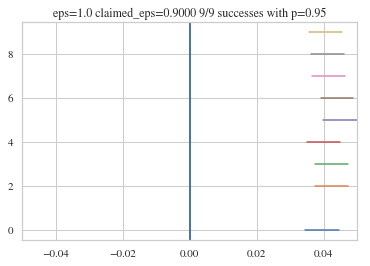

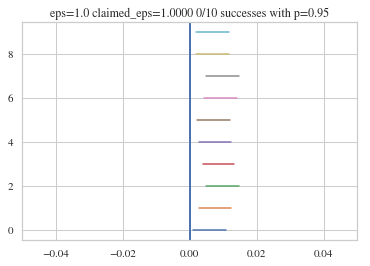

In [ ]:
def success(delta_lb, delta_ub, eps, claimed_eps):
    if claimed_eps == eps:
        return 1 if delta_lb < 0 < delta_ub else 0
    if claimed_eps > eps:
        return 1 if delta_ub < 0 else 0
    if claimed_eps < eps:
        return 1 if delta_lb > 0 else 0

def plot_eps(expm, CLAIMED_EPS):
    try:
        AAs = Alls[expm].requires()
    except KeyError:
        return
    DF = load_completed_AAs_into_dataframe(AAs)
    eps, CLAIMED_EPS = expm.eps, expm.claimed_eps
    plt.figure()
    n_trials = 0
    n_successes = 0
    for (i,CLBD) in enumerate(AAs):
        try:
            with CLBD.output().open() as f:
                pass
        except FileNotFoundError:
            continue
        with CLBD.output().open() as f:
            deltas = dill.load(f)
            n_trials += 1
            n_successes += success(deltas['lower_bound'],
                                   deltas['upper_bound'],
                                   eps=eps,
                                   claimed_eps=CLAIMED_EPS)
    #         print(i, deltas)
            plt.plot([deltas['lower_bound'], deltas['upper_bound']], [i, i])
        plt.axvline(0)
    plt.title(f'eps={eps} claimed_eps={CLAIMED_EPS:.4f}'
              f' {n_successes}/{n_trials} successes with p={asys(eps)["p"]:.2f}')
    plt.xlim([-0.05, 0.05])

    
for expm in sorted(Alls.keys(),key=lambda expm: expm.eps):
    plot_eps(expm, CLAIMED_EPS)

In [6]:
eps=0.001
CLAIMED_EPS = eps
probability_of_natural_sample = 1 / (exp(CLAIMED_EPS))
probability_of_alternative_sample = 1 - probability_of_natural_sample
expected_accuracy = 0.5 + 0.5 * probability_of_alternative_sample
print(probability_of_natural_sample)
print(expected_accuracy)

0.9990004998333749
0.5004997500833126


### Inspect `statistical_distance = f(n_trials)` for a single document


In [7]:
from experiment_framework.asymptotic_analysis import ComputeAsymptoticAccuracy
from experiment_framework.utils import calculations

import copy
from functools import lru_cache
from matplotlib import cm


AAType = type(AAs[expm][0])

DF = load_completed_CCCs_into_dataframe(CCCs[expm])
DF_doc0 = DF[DF.doc_ind==0]

DF_doc0.head(n=2)

from matplotlib import cm
experiments = sorted(Alls.keys(),key=lambda expm: expm.eps)
colors = cm.Accent(np.linspace(0, 1, len(experiments) + 1))

In [8]:
n_trials_max = asys['n_trials_for_largest_training_set_size']

kwargs_to_remove = ['gen_sample_kwargs', 'fitter', 'fitter_kwargs', 'n_docs', 'p']

trial_space = sorted(list(set(
    np.logspace(start=0.5,
                stop=np.log(n_trials_max)/np.log(10),
                num=30).astype(np.int))
))

print(trial_space)
colors = cm.Accent(np.linspace(0, 1, 2*len(experiments) + 1))


def get_df(expm):
    convergence_AAs = []
    
    eps, claimed_eps = expm
    
    for n_trials in trial_space:
        asys_ntrials = copy.deepcopy(asys)
        asys_ntrials['n_trials_for_largest_training_set_size'] = n_trials
        asys_ntrials['confidence_interval_prob'] = asys['p']
        asys_ntrials['dataset_settings'] = dses[epsilons.index(eps)]
        asys_ntrials['dataset_settings']['doc_ind'] = 0
        asys_ntrials['dataset_settings']['claimed_epsilon'] = claimed_eps
        asys_ntrials['in_memory'] = True
        asys_ntrials['n_bootstraps'] = 10_000
        for kwarg in kwargs_to_remove:
            asys_ntrials.pop(kwarg)

        convergence_AAs.append(AAType(**asys_ntrials))

    luigi.build(convergence_AAs, workers=2, log_level='CRITICAL')
    DF = load_completed_AAs_into_dataframe(convergence_AAs)
    return DF

def plot_bounds_convergence(expm, color=None):
    DF = get_df(expm)
#     plt.figure(figsize=(14,10))
    plt.plot(DF.n_trials_for_largest_training_set_size, DF.lb_two_sided, '-*b')
    plt.plot(DF.n_trials_for_largest_training_set_size, DF.ub_two_sided, '-*r')
    plt.xlabel('n trials per training set size')
    plt.ylabel('accuracy')
    plt.legend(['lower bound', 'upper bound'])
    plt.title(expm)

    
plt.figure(figsize=(14,10))
for expm in sorted(Alls.keys(),key=lambda expm: expm.eps):
    plot_bounds_convergence(expm)
_ = plt.xticks(trial_space, rotation=60)

TypeError: 'function' object is not subscriptable

In [ ]:



def plot_bound_size(expm, color_i):
    DF = get_df(expm)
    eps, claimed_eps = expm
    color = 'b'
    if color_i is not None:
        color = colors[color_i]
#     plt.figure(figsize=(14,10))
    sd_bound = np.abs(calculations.accuracy_to_statistical_distance(DF.ub_two_sided)
                      - calculations.accuracy_to_statistical_distance(DF.lb_two_sided))
    ax1 = plt.gca()
#     ax2 = ax1.twinx()

    ax1.semilogy(DF.n_trials_for_largest_training_set_size, sd_bound , '-*',
                 color=color, linewidth=3)
    ax1.semilogy(DF.n_trials_for_largest_training_set_size, np.exp(claimed_eps)*sd_bound, '-.',
                 color=color, linewidth=3)
#     plt.title(expm)

plt.figure(figsize=(14,10))
ax1 = plt.gca()
ax1.set_xlabel('n trials per training set size')
ax1.set_ylabel('bound width')
for (i, expm) in enumerate(experiments):
    plot_bound_size(expm, i)

# plt.legend(experiments, fontsize=20)
plt.legend(
    list(itertools.chain(*[[f'SD bound {expm}', f'delta bound {expm}']
                           for expm in experiments])),
    fontsize=20,
    loc=(0, 1.05)
)
_ =plt.xticks([trial_space[i] for i in [0,15,18]]+trial_space[20:],
              rotation=60, fontsize=18)
yt = np.linspace(0.01, 0.1, num=10)
_ = plt.yticks(yt, yt, fontsize=18)

In [ ]:
DF = get_df(experiment(eps=0.01, claimed_eps=0.01*1.1))

In [ ]:
print(asys['validation_set_size'])

print(DF[DF.n_trials_for_largest_training_set_size==999].ub_two_sided - DF[DF.n_trials_for_largest_training_set_size==999].lb_two_sided)

print(DF[DF.n_trials_for_largest_training_set_size==62].ub_two_sided - DF[DF.n_trials_for_largest_training_set_size==62].lb_two_sided)

In [ ]:
print(asys['validation_set_size'])

print(DF[DF.n_trials_for_largest_training_set_size==999].ub_two_sided - DF[DF.n_trials_for_largest_training_set_size==999].lb_two_sided)

print(DF[DF.n_trials_for_largest_training_set_size==62].ub_two_sided - DF[DF.n_trials_for_largest_training_set_size==62].lb_two_sided)